In [2]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values # 30 features
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y) # transform class labels form string represejtation onto integers

In [4]:
# (M=malignant=1, B=benign=0)
le.transform(['M', 'B'])

array([1, 0])

In [5]:
# divide dataset into training dataset (80 %) and test dataset (80%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.20, random_state=1)

In [6]:
# pipeline takes list of tuples as input, first value arbitrry identifier string, second element is scikit-learn
# transformer or estimator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                ('pca', PCA(n_components=2)), # reduce to 2-D
                ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [7]:
# k-fold cross-validation to assess model performance

# holdout cross-validation
# separate data into three parts: training set, validation set and a test set
# training set used to fit different models, 
# validation set is used for model selection (tuning parameters / hyperparameters)
# test set used for evaluating model's generalization error
# Drawback: performance estimate is sensitive to how we partition training and validation subsets

# k-fold cross-validation
# randomly split training dataset into k folds without replacement where k-1 folds are used for the model training and
# one fold use for testing. Repeat k times to obtain k models and performance estimates.
# Standard value for k is 10.

# Stratified cross-validation, class proportions are preserved in each fold (representative of class proportions in 
# training set)
# can yield better bias and variance estimates, esp in cases of unequal class proportions

import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [8]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [9]:
# scikit-learn k-fold cross-validation scorer
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1) # no. of cpus, -1 to use all available
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [10]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


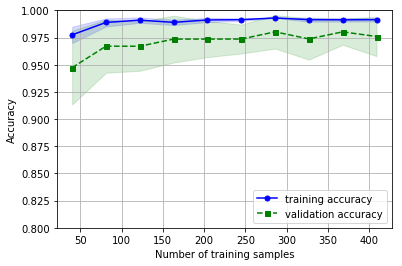

In [11]:
# Debuging algorithms with learning and validation curves

# Diagnosing bias and variance problems with learning curves
# Plot model training and validation accuracies as functions of training set size 
# to detect high variance or high bias

# Evaluate model using learning curve function from scikit-learn
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
%matplotlib inline

pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipe_lr,
                   X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1.0, 10),
                  cv=10,
                  n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',
        marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

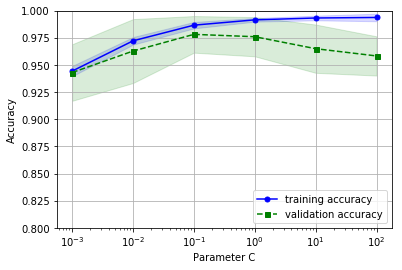

In [13]:
# Validation curves to address overfitting and underfitting
# vary values of model parameters

from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,    
    X=X_train,
    y=y_train,
    param_name='clf__C', # regularization parameter C
    param_range=param_range,
    cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')
plt.plot(param_range, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='validation accuracy')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

In [14]:
# Tuning hyperparameters via grid search
# brute force exhaustive search -> compute model performance for each combination of hyperparameter values

from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC(random_state=1))]) # support vector machine
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,
              'clf__kernel': ['linear']},
             {'clf__C': param_range,
             'clf__gamma': param_range,
             'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [15]:
# use independent test dataset to estimate performance of best model
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [16]:
# Grid search can be expensive, can use RandomizedSearchCV instead

In [18]:
# Algorithm selection with nested cross-validation
# Outer k-fold cross-validation to split data into training and test folds
# Inner loop to select model using k-fold cross-validation on training fold

# 5 x 2 cross-validation

# inner k-fold cross validation to tune parameters
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2,
                 n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5) # outer k-fold cross validation
print('CV accuracy: %.3f +/- %.3f' % (
    np.mean(scores), np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [21]:
# average cv accuracy gives good estimate of what to expect if we tune the hyperparameters of a model and then use
# it on unseen data.

# E.g. use nested cross-validation approach to compare an SVM model to a simple decision tree classifier
# tune depth parameter

from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring='accuracy',
                 cv=5)

scores = cross_val_score(gs,
                        X_train,
                        y_train,
                        scoring='accuracy',
                        cv=2)
print('CV accuracy: %.3f +/- %.3f' % (
    np.mean(scores), np.std(scores)))


CV accuracy: 0.906 +/- 0.015


In [24]:
# Looking at different performance evaluation metrics

# Confusion matrix: true positive, true negative, false positive, false negative

from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


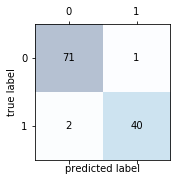

In [27]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range (confmat.shape[1]):
        ax.text(x=j, y=i,
               s=confmat[i, j],
               va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# assume class 1 (malignant) is the positive class
# 71 true negatives and 40 true positives
# 1 false positive, 2 false negative

In [31]:
# Optimizing the precision and recall of a classification model
# Prediction Error (ERR) = (FP + FN) / (FP + FN + TP + TN)
# Prediction Accuracy (ACC) = (TP + TN) / (FP + FN + TP + TN) = 1 - ERR
# True positive rate (TPR) = TPR = TP / P = TP / (FN + TP)
# False positive rate (FPR) = FP / N = FP / (FP + TN)
# Precision (PRE) = TP / (TP + FP)
# Recall = TPR = TP / P = TP / (FN + TP)
# F1 = 2[(PRE * REC) / (PRE + REC)]

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(
    y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(
    y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(
    y_true=y_test, y_pred=y_pred))

# Furthermore, GridSearch can accept different scoring metric other than accuracy

Precision: 0.976
Recall: 0.952
F1: 0.964


In [34]:
# Positive class in scikit-learn is the class labeled as 1
# To change positive label, use make_scorer
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10)

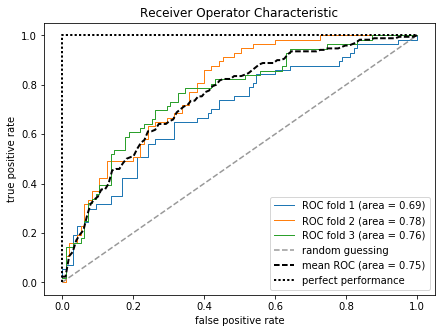

In [59]:
# Plotting receiver operating characteristic (ROC)
# ROC graphs for selecting models for classification based on performance
# w.r.t false positive and true positive rates
# discrimination threshold is varied
# Diagonal of ROC can be interpreted as random guessing, classification models falling below diagonal considered
# worse than random guessing.
# Perfect classifier would fallinto top left corner of the graph with TPR 1 and FPR 0.
# Can compute area under curve (AUC) from ROC graph to characterize performance of classification model.

# Similar: precision-recall curves

from sklearn.metrics import roc_curve, auc
from scipy import interp
pipe_lr = Pipeline([('scl', StandardScaler()),
                   ('pca', PCA(n_components=2)),
                   ('clf', LogisticRegression(penalty='l2',
                                             random_state=0,
                                             C=100.0))])
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = [0.0]
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                        y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr) # linear estimation of mean_tpr at x_cords mean_fpr, using tpr
    #mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
            tpr,
            lw=1,
            label = 'ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
# baseline - random guessing
plt.plot([0, 1],
        [0, 1],
        linestyle='--',
        color=(0.6, 0.6, 0.6),
        label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
# mean of 3 classifiers
plt.plot(mean_fpr, mean_tpr, 'k--',
        label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
# perfect performance curve
plt.plot([0, 0, 1],
        [0, 1, 1],
        lw=2,
        linestyle=':',
        color='black',
        label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [61]:
# roc score
pipe_lr = pipe_lr.fit(X_train2, y_train)
y_pred2 = pipe_lr.predict(X_test[:, [4, 14]])
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.662
Accuracy: 0.711


In [62]:
# Scoring metrics for multiclass classification
# Extend scoring metrics to multiclass problems via One vs. All (OvA) classification
# PREmicro = (TP1 + ... + TPk) / (TP1 + ... + TPk + FP1 + ... + FPk) # weigh each instance equally
# PREmacro = (PRE1 + ... + PREk) / k # evaluate overall performance of classifier

# by default, binary performance metrics on multiclass classification in scikit-learn uses weighted variant
# of macro-average - weighting the score of each class label by number of true instances - useful when
# dealing with imbalances

# To specify explicitly:

pre_scorer = make_scorer(score_func=precision_score,
                        pos_labe=1,
                        greater_is_better=True,
                        average='micro')